<a href="https://colab.research.google.com/github/rimchristian/sales-prediction/blob/main/salesprediction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Goal of the Task**


###The goal is to help the retailer understand the properties of products and outliets to predict sales

### **Data Dictionary:**

**Attribute** | **Description**  
--- | ---
Item_Identifer | Unique product id
Item_Weight | Weight of Product
Item_Fat_Content | Whether the product is low fat or regular 
Item_Visibility  | Percentage of total display area of all products in a store allocated in the particlar product
Item_Type | The cateogry to which the product belongs
Item_MRP | Maximum Retail Price of the product
Outlet_Identifier | Unique store id
Outlet_Establishment_Year | The year in whch store was established
Outlet_Size | The size of the store in terms of ground area covered
Outlet_location_type | The type of area in which the storoe is located
Outlet_Type | Whether the outlet is a grocery store or some sort of supermarket
Item_Outlet_Sales | Sales of the product in the particular store. This is the target variable to be predicted. 


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

# Regression Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Set global scikit_learn configuration
from sklearn import set_config
set_config(display='diagram')

In [ ]:
# Create a function to take the true and predicted values
# and print MAE, MSE, RMSE, and R2 metrics
def evaluation_model(pipe, model_name='', 
                     x_train='X_train', x_test='X_test'):
  # Train
  mae = round(mean_absolute_error(y_train, pipe.predict(x_train)),4)
  mse = round(mean_squared_error(y_train, pipe.predict(x_train)),4)
  rmse = round(np.sqrt(mean_squared_error(y_train, pipe.predict(x_train))),4)
  r2 = round(r2_score(y_train, pipe.predict(x_train)),7)
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

  # Test
  mae = round(mean_absolute_error(y_test, pipe.predict(x_test)),4)
  mse = round(mean_squared_error(y_test, pipe.predict(x_test)),4)
  rmse = round(np.sqrt(mean_squared_error(y_test, pipe.predict(x_test))),4)
  r2 = round(r2_score(y_test, pipe.predict(x_test)),7)

  # Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

In [ ]:
filename = '/content/sales_predictions.csv'
df = pd.read_csv(filename,decimal=',')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047301,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138
1,DRC01,5.92,Regular,0.019278216,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.5,Low Fat,0.016760075,Meat,141.618,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.27
3,FDX07,19.2,Regular,0,Fruits and Vegetables,182.095,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


###**Inspect the Data**

In [ ]:
df.dtypes

Item_Identifier              object
Item_Weight                  object
Item_Fat_Content             object
Item_Visibility              object
Item_Type                    object
Item_MRP                     object
Outlet_Identifier            object
Outlet_Establishment_Year     int64
Outlet_Size                  object
Outlet_Location_Type         object
Outlet_Type                  object
Item_Outlet_Sales            object
dtype: object

In [ ]:
# onverting into a float
df['Item_Outlet_Sales'] = df['Item_Outlet_Sales'].astype('float')
df.dtypes

Item_Identifier               object
Item_Weight                   object
Item_Fat_Content              object
Item_Visibility               object
Item_Type                     object
Item_MRP                      object
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [ ]:
# displaying the descriptive statistics for the object columns
df.describe(include='object')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,7060,8523,8523,8523,8523,8523,6113,8523,8523
unique,1559,415,5,7880,16,5938,10,3,3,4
top,FDW13,12.15,Low Fat,0,Fruits and Vegetables,172.0422,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,86,5089,526,1232,7,935,2793,3350,5577


In [ ]:
# displaying the descriptive statistics for nume4ric columns
df.describe(include='number')

,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000
mean,1997.831867,2181.288914
std,8.371760,1706.499616
min,1985.000000,33.290000
25%,1987.000000,834.247400
50%,1999.000000,1794.331000
75%,2004.000000,3101.296400
max,2009.000000,13086.964800


##**Cleaning the data**

In [ ]:
# Display the number of duplicate rows in the data
print(f'There are {df.duplicated().sum()} duplicate rows.')


There are 0 duplicate rows.


In [ ]:
# identifying missing data 
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
# split
X = df.drop(columns=['Item_Outlet_Sales','Item_Identifier','Item_Weight', 'Item_Visibility','Item_Type','Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Fat_Content', 'Outlet_Identifier'])
y = df['Item_Outlet_Sales']

# split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

## **Prepare the Data**

### **ColumnSelector**

In [ ]:
# Instantiate the column seelctors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

### **Transformers**

In [ ]:
#scaler
scaler = StandardScaler()
# One hot Encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
# Instantiate an imputer and scaler 
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

In [ ]:
#create tuples
num_tuple = (mean_imputer,num_selector)
cat_tuple = (freq_imputer, cat_selector)

# instantiate ColumnTransformer
col_transformer = make_column_transformer(num_tuple,cat_tuple,remainder='passthrough')
col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('simpleimputer-1', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fce6290a940>),
                                ('simpleimputer-2',
                                 SimpleImputer(strategy='most_frequent'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fce6290a1c0>)])

In [ ]:
# fit ColumnTransformer on the training data
col_transformer.fit(X_train)
# transform both the training and testing data
X_train_imputed = col_transformer.transform(X_train)
X_test_imputed = col_transformer.transform(X_test)
# change the result back to a dataframe
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_train_imputed.isna().any()
                                        

Item_MRP                     False
Outlet_Establishment_Year    False
dtype: bool

In [ ]:
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer,scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [ ]:
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer,ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

### **ColumnTransformer**

In [ ]:
# ColumnTransformer
preprocessor = make_column_transformer(num_tuple,cat_tuple,remainder='drop')
preprocessor

ColumnTransformer(transformers=[('simpleimputer-1', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fce6290a940>),
                                ('simpleimputer-2',
                                 SimpleImputer(strategy='most_frequent'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fce6290a1c0>)])

## **Data Modeling**

### **Baseline Model**

In [ ]:
# creating an instance of the model
dummy = DummyRegressor(strategy='mean')

# creating a model pipeline
dummy_pipe = make_pipeline(preprocessor, dummy)

# fitting the model
dummy_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer-1',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fce6290a940>),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fce6290a1c0>)])),
                ('dummyregressor', DummyRegressor())])

##**Metrics**

In [ ]:
# Displaying model performance metrics using a function
evaluation_model(pipe=dummy_pipe, model_name='Dummy Model', x_train=X_train, x_test=X_test)

Dummy Model Train Scores
MAE: 1,360.2184 
MSE: 2,959,455.7045 
RMSE: 1,720.3069 
R2: 0.0000

Dummy Model Test Scores
MAE: 1,326.1210 
MSE: 2,772,144.4627 
RMSE: 1,664.9758 
R2: -0.0048



##**Model 1: Building Linear Regression Model**


In [ ]:
# creating an instance of the model
lin_reg = LinearRegression()

# creating a model pipeline
lin_reg_pipe = make_pipeline(preprocessor, lin_reg)

# fitting the model
lin_reg_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer-1',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fce6290a940>),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fce6290a1c0>)])),
                ('linearregression', LinearRegression())])

In [ ]:
# displaying model performance metrics with a function
evaluation_model(pipe=lin_reg_pipe, model_name='Linear Regression Model', x_train=X_train, x_test=X_test)

Linear Regression Model Train Scores
MAE: 1,038.3505 
MSE: 1,997,551.6054 
RMSE: 1,413.3477 
R2: 0.3250

Linear Regression Model Test Scores
MAE: 1,004.1899 
MSE: 1,873,063.7979 
RMSE: 1,368.5992 
R2: 0.3211



In [ ]:
predictions = lin_reg_pipe.predict(X_test)
predictions

array([1372.64605243,  672.8177138 ,  637.03871145, ..., 3225.6437947 ,
       1837.23631132, 2203.28001411])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Create model pipeline
train_pred = lin_reg_pipe.predict(X_train)
test_pred = lin_reg_pipe.predict(X_test)

##**R-Squared**

In [ ]:
# R^2 coefficient of determination

train_r2 = np.corrcoef(y_train, train_pred)[0][1]**2
test_r2 = np.corrcoef(y_test, test_pred)[0][1]**2

print(f' Model Training R2: {train_r2}')
print(f' Model Testing R2: {test_r2}')

 Model Training R2: 0.32502736826006295
 Model Testing R2: 0.32230188174466606


##**Root Mean Squared Error**

In [ ]:
# Measuring RMSE
train_RMSE = np.sqrt(np.mean(np.abs(train_pred - y_train)**2))
test_RMSE = np.sqrt(np.mean(np.abs(test_pred - y_test)**2))

print(f' Model Training RMSE: {train_RMSE}')
print(f' Model Testing RMSE: {test_RMSE}')

 Model Training RMSE: 1413.3476590712073
 Model Testing RMSE: 1368.5992101132697


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
# importing the linearregression library
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [ ]:
# making the Item Fat Content column more consistent
df['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'}, inplace=True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

##**Regression Metric: Mean Squared Error**

In [ ]:
# calculating mse
train_mse = mean_squared_error(y_train,train_pred)
test_mse = mean_squared_error(y_test,test_pred)

print(f'Model Training: {train_mse}')
print(f'Model Testing: {test_mse}')

Model Training: 1997551.6054020615
Model Testing: 1873063.797922666


##**Metric for Linear Regression Model**
- The MSE is more useful for the linear regression model, because it penalizes larger erros. The Model test results is lower than the train dataset, which means is better. 

##**Model 2: Regression Tree Model**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dec_tree = DecisionTreeRegressor(random_state=42) # creates the regression tree model


In [ ]:
dec_tree.fit(X_train, y_train) # figures out how it should make predictions in future data

DecisionTreeRegressor(random_state=42)

In [ ]:
# predicting the target values
train_preds = dec_tree.predict(X_train)
test_preds = dec_tree.predict(X_test)



In [ ]:
# evauluating the model
train_score = dec_tree.score(X_train,y_train)
test_score = dec_tree.score(X_test,y_test)

print(train_score)
print(test_score)

0.9770305627951709
-0.1812493379076403


The result for the tree model shows that it is way overfitting.  I will go ahead and tune my model. 

In [ ]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
dec_tree.get_depth()

32

In [ ]:
dec_tree.get_n_leaves()

6157

In [ ]:
# finding the right optimal max_depth. I will try different parameters on the max depth. I will set it to 8
dec_tree_8 = DecisionTreeRegressor(max_depth=8, random_state=42)
dec_tree_8.fit(X_train,y_train)
train_8_score = dec_tree_8.score(X_train,y_train)
test_8_score = dec_tree_8.score(X_test,y_test)
print(train_8_score)
print(test_8_score)

0.4871112308669121
0.335129178241777


In [ ]:
# finding the right optimal max_depth. I will try different parameters on the max depth. I will set it to 18
dec_tree_14 = DecisionTreeRegressor(max_depth=14, random_state=42)
dec_tree_14.fit(X_train,y_train)
train_14_score = dec_tree_14.score(X_train,y_train)
test_14_score = dec_tree_14.score(X_test,y_test)
print(train_14_score)
print(test_14_score)

0.7136821370142619
0.08830647351694743


In [ ]:
# List of values to try for max_depth:
depths = list(range(2, 9)) # Will input every value between 2 and 28
# Data frame to store the score for each value of max_depth:
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train, y_train)
    train_score = dec_tree.score(X_train, y_train)
    test_score = dec_tree.score(X_test, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score


Text(0, 0.5, 'R2')

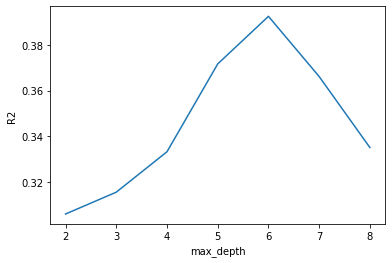

In [ ]:
import matplotlib.pyplot as plt
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2')

In [ ]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head(8)

,Test Score,Train Score
6,0.392557,0.437989
5,0.371732,0.404251
7,0.366204,0.463358
8,0.335129,0.487111
4,0.333298,0.348056
3,0.315607,0.323975
2,0.306049,0.305669


In [ ]:
# Let's run the model with our optimized value for max_depth
dec_tree_6 = DecisionTreeRegressor(max_depth = 6, random_state = 42)
dec_tree_6.fit(X_train, y_train)
train_6_score = dec_tree_6.score(X_train, y_train)
test_6_score = dec_tree_6.score(X_test, y_test)
print(train_6_score)
print(test_6_score)


0.4379894023439658
0.39255745390098207


From the model we have built for the Tree model, the greatest value for max_depth is 6.  The training score is higher than the testing score.  

**R-Squared Regression Metric**

The R2 metric shows that there is a 32% variance in the model. It is low R-Squared model. This trend indicates that the predictor variable still provides information about the response even though the data points are further away from each other.  From the regression tree model, it is about 7 points higher than the R2.  Therefore,  it is overfitting.   

In [ ]:
# Calculating R2
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(f'Model Training: {train_r2}')
print(f'Model Testing: {test_r2}')

Model Training: 0.32502736826006273
Model Testing: 0.3211021322282346


**Root Mean Squared Error Regression Metric**

In the case of the RMSE, the model decreases by around 85.  It is in close proximity from each other; therefore it shows a pretty good model for the RMSE.

In [ ]:
# Measuring RMSE
train_RMSE = np.sqrt(np.mean(np.abs(train_pred - y_train)**2))
test_RMSE = np.sqrt(np.mean(np.abs(test_pred - y_test)**2))

print(f' Model Training RMSE: {train_RMSE}')
print(f' Model Testing RMSE: {test_RMSE}')

 Model Training RMSE: 1413.3476590712073
 Model Testing RMSE: 1368.5992101132697


##Regression Metrics
Based on the R-squared, our model can account for about 32%.  
The correlation coeffciant is low, so the model isn't really strong.  It measures the variance of the model.
For the **regression tree model**, the r^2 is better because it is in the same range than the MSE. 
- The R-squared is, essentially, a goodness-of-fit measure for linear regression models.  The testing and training dataset is similar, so the variance is quite consistent. 

##**Model Comparison**

Based on the two models, I would recommend using the RMSE because it handles the penalization of smaller errors. 